In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cesnet_datazoo.datasets import CESNET_QUIC22
from cesnet_datazoo.config import DatasetConfig
from datetime import datetime, timedelta

from scipy import stats
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore') 

In [4]:
data = CESNET_QUIC22("./datasets/QUIC/", size="XS")

dataset_config = DatasetConfig(dataset=data, train_period="W-2022-44")
data.set_dataset_config_and_initialize(dataset_config)
data_ref = data.get_train_df().sample(n=250000,random_state=42)

dataset_config = DatasetConfig(dataset=data, train_period="W-2022-45")
data.set_dataset_config_and_initialize(dataset_config)
data_curr = data.get_train_df().sample(n=250000,random_state=42)



Loading data from dataloader


100%|██████████| 8162/8162 [00:08<00:00, 991.85it/s] 


Loading data from dataloader


100%|██████████| 10634/10634 [00:11<00:00, 932.65it/s]


In [12]:
from detector.detector import DriftDetector, Config
from detector.test import KSTest, WassersteinTest

feat_names = ['BYTES','BYTES_REV','PACKETS','PACKETS_REV','PPI_LEN','PPI_ROUNDTRIPS','PPI_DURATION','DURATION','PSIZE_BIN1','PSIZE_BIN2',
              'PSIZE_BIN3','PSIZE_BIN4','PSIZE_BIN5','PSIZE_BIN6','PSIZE_BIN7','PSIZE_BIN8','PSIZE_BIN1_REV','PSIZE_BIN2_REV','PSIZE_BIN3_REV',
              'PSIZE_BIN4_REV','PSIZE_BIN5_REV','PSIZE_BIN6_REV','PSIZE_BIN7_REV','PSIZE_BIN8_REV','IPT_BIN1','IPT_BIN2','IPT_BIN3','IPT_BIN4',
              'IPT_BIN5','IPT_BIN6','IPT_BIN7','IPT_BIN8','IPT_BIN1_REV','IPT_BIN2_REV','IPT_BIN3_REV','IPT_BIN4_REV','IPT_BIN5_REV','IPT_BIN6_REV',
              'IPT_BIN7_REV','IPT_BIN8_REV']

global_config = Config(
    chosen_features = feat_names,
    drift_test=WassersteinTest()
)

class_config = Config(
    chosen_features = feat_names,
    drift_test=KSTest(),
    class_name="APP"
)

detector = DriftDetector(global_config, class_config)

print("Drift detected?")
display(detector.detect(data_ref,data_curr))
print("Drifted features:")
display(detector.get_drifted_features())
print("Drift statistics:")
display(detector.get_drift_statistics())
print("Class drift:")
display(detector.get_class_drift())

Drift detected?


False

Drifted features:


PSIZE_BIN5_REV    0.247910
PSIZE_BIN4_REV    0.127046
Name: distance, dtype: float64

Drift statistics:


{'is_drifted': False,
 'drift_strength': 0.030454746023385288,
 'share_drifted_features': 0.05}

Class drift:


drift_strength  share_drifted  is_drifted
Class_99         0.067778          0.875        True
Class_100        0.071608          0.875        True
Class_97         0.089090          0.825        True
Class_98         0.091340          0.850        True
Class_19         0.133506          0.725        True
...                   ...            ...         ...
Class_1          0.801229          0.025       False
Class_9          0.808853          0.000       False
Class_46         0.865127          0.125       False
Class_63         0.870074          0.125       False
Class_40         0.875000          0.125       False

[101 rows x 3 columns]

We can see that feature PSIZE_BIN5_REV is heavily drifted, together with slightly feature PSIZE_BIN4_REV. Even though the global drift in the whole dataset was mot detected, we can see that several classes are completely drifted. 

### Behaviour of PSIZE_BIN5_REV

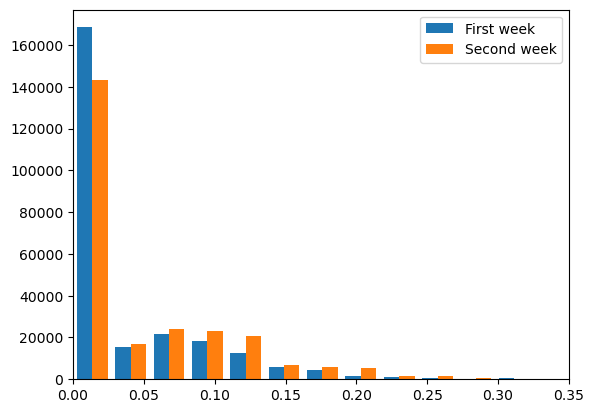

In [20]:
plt.hist([data_ref.PSIZE_BIN5_REV, data_curr.PSIZE_BIN5_REV],bins = 30, label=['First week', 'Second week'])
plt.xlim((0,0.35))
plt.legend()
plt.show()

### Behaviour of  drifted classes
Let's create a second detector to analyse the most drifted class.

In [21]:
data_ref = data_ref[data_ref.APP == 99]
data_curr = data_curr[data_curr.APP == 99]

global_config = Config(
    chosen_features = feat_names,
    drift_test=WassersteinTest()
)

detector99 = DriftDetector(global_config)

print("Drift detected?")
display(detector99.detect(data_ref,data_curr))

print("Drifted features:")
display(detector99.get_drifted_features())
display(detector99.get_drift_statistics())

Drift detected?


True

Drifted features:


BYTES_REV         8.907824
PACKETS_REV       7.305879
PACKETS           3.474867
PSIZE_BIN4_REV    3.119147
PSIZE_BIN3_REV    2.910555
BYTES             2.327488
PSIZE_BIN2_REV    2.305206
PSIZE_BIN8_REV    1.678467
IPT_BIN2_REV      1.575703
IPT_BIN1_REV      1.192692
PSIZE_BIN3        1.073988
PSIZE_BIN7_REV    1.013005
PSIZE_BIN8        0.863182
PSIZE_BIN7        0.720236
IPT_BIN4_REV      0.684845
PSIZE_BIN6        0.596259
PPI_LEN           0.596061
IPT_BIN5_REV      0.546395
PSIZE_BIN5_REV    0.485686
PSIZE_BIN6_REV    0.485578
IPT_BIN5          0.465506
IPT_BIN6_REV      0.432073
IPT_BIN2          0.413813
PSIZE_BIN4        0.413766
IPT_BIN8          0.345579
IPT_BIN1          0.345007
IPT_BIN3_REV      0.340245
IPT_BIN8_REV      0.301714
PSIZE_BIN5        0.259713
IPT_BIN3          0.248931
PPI_ROUNDTRIPS    0.191981
IPT_BIN7          0.153309
PPI_DURATION      0.129430
IPT_BIN6          0.126758
IPT_BIN7_REV      0.113186
DURATION          0.109421
Name: distance, dtype: float

{'is_drifted': True,
 'drift_strength': 1.158741589353952,
 'share_drifted_features': 0.9}

We can notice severly drifted features. In further analysis, one may study the distribution of the most drifted feature or of the whole dataset using dimensionality reduction as seen in the following graphs.

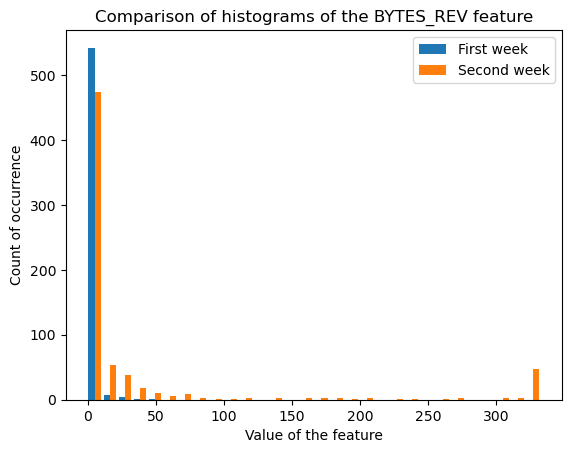

In [42]:
plt.hist([data_ref.BYTES_REV, data_curr.BYTES_REV],bins = 30, label=['First week', 'Second week'])
plt.title("Comparison of histograms of the BYTES_REV feature")
plt.ylabel("Count of occurrence")
plt.xlabel("Value of the feature")
plt.legend()
plt.show()

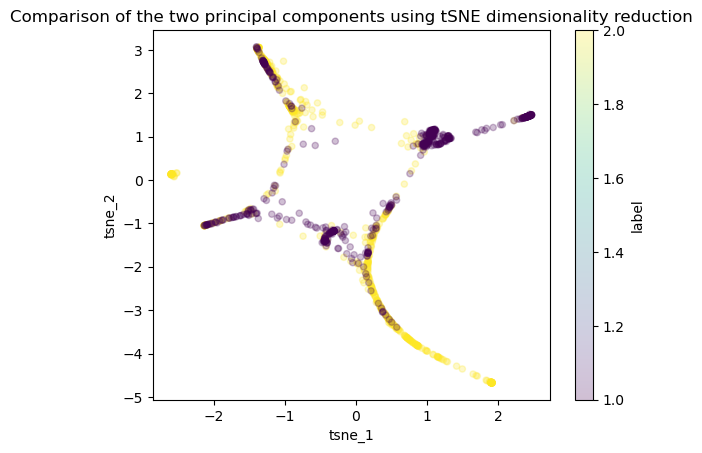

In [46]:
from sklearn import datasets, manifold
data=pd.concat([data_curr,data_ref])
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)
tsne_result = t_sne.fit_transform(data.drop(columns=["PPI","APP","week"]))

df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': data.week})
df.plot.scatter(x="tsne_1",y="tsne_2",c="label",colormap='viridis', alpha = 0.25)
plt.title("Comparison of the two principal components using tSNE dimensionality reduction")
plt.show()